In [110]:
import qsharp

In [111]:
%%qsharp

    open Microsoft.Quantum.Canon;
    open Microsoft.Quantum.Intrinsic;
    open Microsoft.Quantum.Measurement;
    open Microsoft.Quantum.Arrays;
    open Microsoft.Quantum.Convert;
    open Microsoft.Quantum.Diagnostics;
    open Microsoft.Quantum.Math;
    
    ///Credit for all intermediate algorithms: 
    /// "https://tsmatz.wordpress.com/2019/05/22/quantum-computing-modulus-add-subtract-multiply-exponent/"
    /// "https://tsmatz.wordpress.com/2019/06/04/quantum-integer-factorization-by-shor-period-finding-algorithm/""
    
    /// Implement Quantum Phase Estimation using Hadamard, R1Frac and SWAP 
    operation QuantumPhaseTransform(qubits : Qubit[]) : Unit is Adj + Ctl {
        let numberOfQubits = Length(qubits);

        for index in 0 .. numberOfQubits - 1
        {
            ///Apply Hadamard Transfrom to all qubits
            H(qubits[index]);
            for secondIndex in index + 1 .. numberOfQubits - 1
            {
                ///Rotation of |1> state by angle specified, serves as unitary operation to move
                /// qubits to correct state to estimate phase
                Controlled R1Frac([qubits[secondIndex]], (1, secondIndex - index, qubits[index]));
            }
        }

        ///Uses SWAP gate (3 CNOT gates in series) to reverse order of qubits
        SwapReverseRegister(qubits);
    }
    
    /// Drapper's Algorithm : Transform qubit state with phase transformation, convert qubit state using R1Frac, reset qubits with phase transformation

    /// Implement |x> |y> -> |x>|x + y mod 2^n> using Drapper's Algorithm
    /// x = qubitRegister1 , y = qubitRegister2, n is the number of qubits in x
    operation QuantumAddition(qubitRegister1 : Qubit[], qubitRegister2 : Qubit[]) : Unit is Adj + Ctl {
        
        let numberOfQubits = Length(qubitRegister1);
        
        ///Apply QuantumPhaseTransform to set qubit state
        QuantumPhaseTransform(qubitRegister2);
        
        for index in 0 .. numberOfQubits - 1{
            for secondIndex in 0 .. (numberOfQubits - 1) - index{
                ///Rotation of |1> state by angle specified - first argument is numerator second is power
                ///Use R1Frac to achieve mod 2^n
                ///This operation transforms |y> to |x + y mod 2^n>
                Controlled R1Frac([qubitRegister1[index + secondIndex]], (2, secondIndex + 1, (qubitRegister2)[(numberOfQubits - 1) - index]));     
            }
        }
        
        ///Apply QuantumPhaseTransform to reset qubit state
        Adjoint QuantumPhaseTransform(qubitRegister2);
    }
    

    /// Implement |x> -> |x + b mod 2^n> using Drapper's Algorithm
    /// x = qubitAddRegister , b = num, n is the number of qubits in x
    operation QuantumAdditionByNumber (qubitAddRegister : Qubit[], num : Int) : Unit is Adj + Ctl {
        
        let numberOfAddQubits = Length(qubitAddRegister);

        ///Apply QuantumPhaseTransform to set qubit state
        QuantumPhaseTransform(qubitAddRegister);

        for index in 0 .. numberOfAddQubits - 1 {
            for secondIndex in 0 .. (numberOfAddQubits - 1) - index{
                ///Similar to QuantumAddition excpet we need a check condition to make sure 'num' has a remainder 
                if(not((num / 2^((numberOfAddQubits - 1) - (index + secondIndex))) % 2 == 0)){
                    ///This operation transforms |x> to |x + b mod 2^n>
                    R1Frac(2, secondIndex + 1, (qubitAddRegister)[(numberOfAddQubits - 1) - index]);
                }
            }
        }
        
        ///Apply QuantumPhaseTransform to reset qubit state
        Adjoint QuantumPhaseTransform(qubitAddRegister);
    }
        
    /// First, add |x> and |y> by Drapper‚Äôs Algorithm, then subtract integer n 
    /// If x + y < N , the result will be 1. Otherwise, 0.
    /// Turn on auxillary bit with CNOT, when first qubit in |y> is |1>.
    /// When auxillary bit is |1>, add n back. 
    /// Finally, set auxillary bit to |0>.

    /// Implement : |x‚ü© |y‚ü© -> |x‚ü©|x+y mod n‚ü© for some integer n
    /// x = qubitAddRegister1, y = qubitAddRegister2, n = value
    operation QuantumAdditionByModulus (value : Int, qubitAddRegister1 : Qubit[], qubitAddRegister2 : Qubit[]) : Unit is Adj + Ctl {
        
        use auxillary = Qubit();

        use controlRegister1 = Qubit();

        use controlRegister2 = Qubit();

        let overflow1 = [controlRegister1] + qubitAddRegister1;

        let overflow2 = [controlRegister2] + qubitAddRegister2;

        QuantumAddition(overflow1, overflow2);

        Adjoint QuantumAdditionByNumber(overflow2, value);

        Controlled X([overflow2[0]], auxillary);

        Controlled QuantumAdditionByNumber([auxillary], (overflow2, value));

        Adjoint QuantumAddition(overflow1, overflow2);

        X(auxillary);

        Controlled X([overflow2[0]], auxillary);

        QuantumAddition(overflow1, overflow2);
    }
    
    // Implement : |y‚ü© -> |a.y mod n‚ü© using Drapper's Algorithm
    /// y = qubitMulRegister , a = mulNum, n is a number given = val
    operation QuantumMulitplyByModulus (val : Int, mulNum : Int, qubitMulRegister : Qubit[]) : Unit is Adj + Ctl{

        let numberOfMulQubits = Length(qubitMulRegister);

        let moduloNum = mulNum % val;

        use operandQubits = Qubit[numberOfMulQubits];

        for index in 0 .. moduloNum - 1{
            ///Apply QuantumAdditionByModulus to set qubits state
            QuantumAdditionByModulus(val, qubitMulRegister, operandQubits);
        }

        /// Operation to convert |y> to |a.y mod n>
        ///Uses SWAP gate (3 CNOT gates in series) to reverse order of qubits
        ///Zipped to concatenate 2 qubit registers after transform has been applied
        ApplyToEachCA(SWAP, Zipped(qubitMulRegister, operandQubits));

        let inverseNum = InverseModI(moduloNum, val);

        for secondIndex in 0 .. inverseNum - 1 {
            ///Apply QuantumAdditionByModulus to reset qubits state
            Adjoint QuantumAdditionByModulus(val, qubitMulRegister, operandQubits);
        }
    }
        
    operation QuantumExponentForPeriod (rem : Int, num : Int, qubitRegister1 : Qubit[], qubitRegister2 : Qubit[]) : Unit {

        let numOfQubitsin1 = Length(qubitRegister1);
        let numOfQubitsin2 = Length(qubitRegister2);

        X(qubitRegister2[numOfQubitsin2 - 1]);

        for index in 0 .. numOfQubitsin1 - 1{

            mutable moduloA = 1;
            for power in 1 .. 2^((numOfQubitsin1-1) - index){

                set moduloA = (moduloA * rem) % num;
            }

            Controlled QuantumMulitplyByModulus([qubitRegister1[index]], (num, moduloA, qubitRegister2));
        }
    }

    operation ReduceBigIntToInt(bigIntNum : BigInt) : Int {

        Fact(BitSizeL(bigIntNum) <= 32, $"Cannot convert to Int. Input is too large");

        mutable result = 0;

        let numberArray = BigIntAsBoolArray(bigIntNum);
        
        let reversedNumberArray = Reversed(numberArray); 

        let size = Length(reversedNumberArray);

        for index in 0 .. size - 1 {

            if(reversedNumberArray[index] and ((size - 1) - index <= 31)) {

                set result = result + (2 ^ ((size - 1) - index));
            }
        }
        
        return result;
    }

    operation ShorsAlgorithmImplmentation (num : Int, secondNum : Int) : Unit {

        let leastNum1 = BitSizeI(num) * 2;
        let leastNum2 = BitSizeI(num);
        
        mutable period = 1;
        
        repeat {

            use (firstRegister, secondRegister) = (Qubit[leastNum1], Qubit[leastNum2]) {

                ApplyToEachCA(H, firstRegister);
                
                DumpMachine();

                QuantumExponentForPeriod(secondNum, num, firstRegister, secondRegister);
                
                DumpMachine();

                mutable tempResult = new Result[leastNum2];

                for index in 0 .. leastNum2 - 1 {
                    set tempResult w/= index <- MResetZ(secondRegister[index]);
                }

                QuantumPhaseTransform(firstRegister);

                mutable result = new Result[leastNum1];
                
                for secondIndex in 0 .. leastNum1 - 1 {
                    set result w/= secondIndex <- MResetZ(firstRegister[secondIndex]);
                }
            
                let resultBoolean = [false] + ResultArrayAsBoolArray(result); 
                let reverseResultBoolean = Reversed(resultBoolean); 
                let resultBigInt = BoolArrayAsBigInt(reverseResultBoolean);

                let gcd = GreatestCommonDivisorL(resultBigInt, 2L^leastNum1);
                let numerator = resultBigInt / gcd;
                let denominator = 2L^leastNum1 / gcd;
                let numBigInt = IntAsBigInt(num);
                let approxFraction = ContinuedFractionConvergentL(BigFraction(numerator, denominator), numBigInt);
                let (approxNumerator, approxDenominator) = approxFraction!;

                mutable periodBigInt = 0L;

                if(approxDenominator < 0L) {
                    set periodBigInt = approxDenominator * -1L;
                }
                else {
                    set periodBigInt = approxDenominator;       
                }
                set period = ReduceBigIntToInt(periodBigInt);
                
                DumpMachine();

                Message($"Measured Fraction : {resultBigInt} / {2L^leastNum1}");
                Message($"Approximated Fraction : {approxNumerator} / {approxDenominator}");
                Message($"Period Candidate : {period}");
            }
        }
        until ((period != 0) and (ExpModI(secondNum, period, num) == 1));
    }
        
    operation Main() : Unit {
        let num = 3;
        let a = 2;
        ShorsAlgorithmImplmentation(num, a);
    }


C:\snippet_.qs(208,38): warning QS3308: Deprecated syntax. Use [] to construct an empty array, or [x, size = n] to construct an array of x repeated n times.
C:\snippet_.qs(216,34): warning QS3308: Deprecated syntax. Use [] to construct an empty array, or [x, size = n] to construct an array of x repeated n times.


In [112]:
Main.simulate()

|0‚ü©	0.2500000000000001 + 0ùëñ
|1‚ü©	0.2500000000000001 + 0ùëñ
|10‚ü©	0.2500000000000001 + 0ùëñ
|2‚ü©	0.2500000000000001 + 0ùëñ
|20‚ü©	0 + 0ùëñ
|3‚ü©	0.2500000000000001 + 0ùëñ
|11‚ü©	0.2500000000000001 + 0ùëñ
|30‚ü©	0 + 0ùëñ
|4‚ü©	0.2500000000000001 + 0ùëñ
|21‚ü©	0 + 0ùëñ
|40‚ü©	0 + 0ùëñ
|5‚ü©	0.2500000000000001 + 0ùëñ
|12‚ü©	0.2500000000000001 + 0ùëñ
|31‚ü©	0 + 0ùëñ
|50‚ü©	0 + 0ùëñ
|6‚ü©	0.2500000000000001 + 0ùëñ
|22‚ü©	0 + 0ùëñ
|41‚ü©	0 + 0ùëñ
|60‚ü©	0 + 0ùëñ
|7‚ü©	0.2500000000000001 + 0ùëñ
|13‚ü©	0.2500000000000001 + 0ùëñ
|32‚ü©	0 + 0ùëñ
|51‚ü©	0 + 0ùëñ
|8‚ü©	0.2500000000000001 + 0ùëñ
|23‚ü©	0 + 0ùëñ
|42‚ü©	0 + 0ùëñ
|61‚ü©	0 + 0ùëñ
|9‚ü©	0.2500000000000001 + 0ùëñ
|14‚ü©	0.2500000000000001 + 0ùëñ
|33‚ü©	0 + 0ùëñ
|52‚ü©	0 + 0ùëñ
|24‚ü©	0 + 0ùëñ
|43‚ü©	0 + 0ùëñ
|62‚ü©	0 + 0ùëñ
|15‚ü©	0.2500000000000001 + 0ùëñ
|34‚ü©	0 + 0ùëñ
|53‚ü©	0 + 0ùëñ
|25‚ü©	0 + 0ùëñ
|44‚ü©	0 + 0ùëñ
|63‚ü©	0 + 0ùëñ
|16‚ü©	0 + 0ùëñ
|35‚ü©	0 + 0ùëñ
|54‚ü©	0 + 0ùëñ
|26‚ü©	0 + 0ùëñ
|45‚ü©	0 + 0ùëñ
|17‚ü©	0 + 0ùëñ
|36‚ü©	0 + 0ùëñ
|55‚ü©	0 + 0ùëñ
|27‚ü©	0 + 0ùëñ
|46‚ü©	0 + 0ùëñ
|18‚ü©	0 + 0ùëñ
|37‚ü©	0 + 0ùëñ
|56‚ü©	0 + 0ùëñ
|28‚ü©	0 + 0ùëñ
|47‚ü©	0 + 0ùëñ
|19‚ü©	0 + 0ùëñ
|38‚ü©	0 + 0ùëñ
|57‚ü©	0 + 0ùëñ
|29‚ü©	0 + 0ùëñ
|48‚ü©	0 + 0ùëñ
|39‚ü©	0 + 0ùëñ
|58‚ü©	0 + 0ùëñ
|49‚ü©	0 + 0ùëñ
|59‚ü©	0 + 0ùëñ

|0‚ü©	0 + 0ùëñ
|1‚ü©	2.9124448921344745E-34 + -2.9847464250977653E-34ùëñ
|10‚ü©	1.8174173888237963E-33 + -1.5297237950498207E-33ùëñ
|2‚ü©	2.9124448921344745E-34 + -2.9847464250977653E-34ùëñ
|20‚ü©	-2.366187706428435E-33 + -9.618861156634334E-33ùëñ
|3‚ü©	3.6674299187153907E-34 + -7.671926924043905E-34ùëñ
|11‚ü©	2.074693544321204E-33 + 1.9070638847072167E-33ùëñ
|30‚ü©	0.2500000000000074 + -6.7645454109929495E-18ùëñ
|4‚ü©	2.9124448921344745E-34 + -2.9847464250977653E-34ùëñ
|21‚ü©	-2.693214678025704E-33 + -1.0762527261983395E-32ùëñ
|40‚ü©	-4.9106522184055014E-33 + -4.6604487127127145E-33ùëñ
|5‚ü©	3.6674299187153907E-34 + -7.671926924043905E-34ùëñ
|12‚ü©	1.8174173888237963E-33 + -1.5297237950498207E-33ùëñ
|31‚ü©	0.2500000000000092 + -3.925231146709439E-17ùëñ
|50‚ü©	2.0612178601513667E-33 + 1.8805431288817825E-34ùëñ
|6‚ü©	3.6674299187153907E-34 + -7.671926924043905E-34ùëñ
|22‚ü©	-2.693214678025704E-33 + -1.0762527261983395E-32ùëñ
|41‚ü©	-3.270347228998112E-33 + -1.0355419806697627E-32ùëñ
|60‚ü©	5.479088264302457E-33 + -4.411719859071212E-33ùëñ
|7‚ü©	-4.550277199579268E-33 + -9.260790259015994E-33ùëñ
|13‚ü©	2.074693544321204E-33 + 1.9070638847072167E-33ùëñ
|32‚ü©	0.2500000000000001 + 0ùëñ
|51‚ü©	4.03572524616331E-34 + -4.529103977688046E-34ùëñ
|8‚ü©	8.007494265947358E-33 + 9.024318978325672E-34ùëñ
|23‚ü©	-2.4210850488272853E-33 + -1.1277839891755367E-32ùëñ
|42‚ü©	-3.270347228998112E-33 + -1.0355419806697627E-32ùëñ
|61‚ü©	-1.4558303841204434E-34 + -1.7620035890168082E-34ùëñ
|9‚ü©	1.8174173888237963E-33 + -1.5297237950498207E-33ùëñ
|14‚ü©	2.074693544321204E-33 + 1.9070638847072167E-33ùëñ
|33‚ü©	0.2500000000000019 + 1.3013323408188947E-17ùëñ
|52‚ü©	2.0612178601513667E-33 + 1.8805431288817825E-34ùëñ
|24‚ü©	0.25000000000000394 + 1.0576706654330031E-16ùëñ
|43‚ü©	-5.92294481378981E-33 + -5.4799406042921105E-33ùëñ
|62‚ü©	-1.4558303841204434E-34 + -1.7620035890168082E-34ùëñ
|15‚ü©	-9.539972921871588E-33 + -1.302397714769818E-32ùëñ
|34‚ü©	0.2500000000000019 + 1.3013323408188947E-17ùëñ
|53‚ü©	4.03572524616331E-34 + -4.529103977688046E-34ùëñ
|25‚ü©	0.25000000000000533 + 4.3070455404876556E-17ùëñ
|44‚ü©	-3.270347228998112E-33 + -1.0355419806697627E-32ùëñ
|63‚ü©	6.672547897869397E-33 + -1.9232108812086778E-34ùëñ
|16‚ü©	0 + 0ùëñ
|35‚ü©	0.2500000000000038 + -4.4744679680369705E-17ùëñ
|54‚ü©	4.03572524616331E-34 + -4.529103977688046E-34ùëñ
|26‚ü©	0.25000000000000533 + 4.3070455404876556E-17ùëñ
|45‚ü©	-5.92294481378981E-33 + -5.4799406042921105E-33ùëñ
|17‚ü©	-2.366187706428435E-33 + -9.618861156634334E-33ùëñ
|36‚ü©	0.2500000000000019 + 1.3013323408188947E-17ùëñ
|55‚ü©	1.2404934266775625E-34 + -1.2608618543944324E-35ùëñ
|27‚ü©	0.2500000000000074 + -6.7645454109929495E-18ùëñ
|46‚ü©	-5.92294481378981E-33 + -5.4799406042921105E-33ùëñ
|18‚ü©	-2.366187706428435E-33 + -9.618861156634334E-33ùëñ
|37‚ü©	0.2500000000000038 + -4.4744679680369705E-17ùëñ
|56‚ü©	-2.3486144589096503E-33 + 2.203595289513567E-34ùëñ
|28‚ü©	0.25000000000000533 + 4.3070455404876556E-17ùëñ
|47‚ü©	1.168892037149382E-33 + -1.7200166753353743E-32ùëñ
|19‚ü©	-2.693214678025704E-33 + -1.0762527261983395E-32ùëñ
|38‚ü©	0.2500000000000038 + -4.4744679680369705E-17ùëñ
|57‚ü©	5.479088264302457E-33 + -4.411719859071212E-33ùëñ
|29‚ü©	0.2500000000000074 + -6.7645454109929495E-18ùëñ
|48‚ü©	0 + 0ùëñ
|39‚ü©	0.25000000000000555 + -4.9651218613756504E-17ùëñ
|58‚ü©	5.479088264302457E-33 + -4.411719859071212E-33ùëñ
|49‚ü©	2.0612178601513667E-33 + 1.8805431288817825E-34ùëñ
|59‚ü©	-1.4558303841204434E-34 + -1.7620035890168082E-34ùëñ

|0‚ü©	1 + -7.242264371514861E-17ùëñ
|1‚ü©	0 + 0ùëñ
|10‚ü©	0 + 0ùëñ
|2‚ü©	0 + 0ùëñ
|20‚ü©	0 + 0ùëñ
|3‚ü©	0 + 0ùëñ
|11‚ü©	0 + 0ùëñ
|30‚ü©	0 + 0ùëñ
|4‚ü©	0 + 0ùëñ
|21‚ü©	0 + 0ùëñ
|40‚ü©	0 + 0ùëñ
|5‚ü©	0 + 0ùëñ
|12‚ü©	0 + 0ùëñ
|31‚ü©	0 + 0ùëñ
|50‚ü©	0 + 0ùëñ
|6‚ü©	0 + 0ùëñ
|22‚ü©	0 + 0ùëñ
|41‚ü©	0 + 0ùëñ
|60‚ü©	0 + 0ùëñ
|7‚ü©	0 + 0ùëñ
|13‚ü©	0 + 0ùëñ
|32‚ü©	0 + 0ùëñ
|51‚ü©	0 + 0ùëñ
|8‚ü©	0 + 0ùëñ
|23‚ü©	0 + 0ùëñ
|42‚ü©	0 + 0ùëñ
|61‚ü©	0 + 0ùëñ
|9‚ü©	0 + 0ùëñ
|14‚ü©	0 + 0ùëñ
|33‚ü©	0 + 0ùëñ
|52‚ü©	0 + 0ùëñ
|24‚ü©	0 + 0ùëñ
|43‚ü©	0 + 0ùëñ
|62‚ü©	0 + 0ùëñ
|15‚ü©	0 + 0ùëñ
|34‚ü©	0 + 0ùëñ
|53‚ü©	0 + 0ùëñ
|25‚ü©	0 + 0ùëñ
|44‚ü©	0 + 0ùëñ
|63‚ü©	0 + 0ùëñ
|16‚ü©	0 + 0ùëñ
|35‚ü©	0 + 0ùëñ
|54‚ü©	0 + 0ùëñ
|26‚ü©	0 + 0ùëñ
|45‚ü©	0 + 0ùëñ
|17‚ü©	0 + 0ùëñ
|36‚ü©	0 + 0ùëñ
|55‚ü©	0 + 0ùëñ
|27‚ü©	0 + 0ùëñ
|46‚ü©	0 + 0ùëñ
|18‚ü©	0 + 0ùëñ
|37‚ü©	0 + 0ùëñ
|56‚ü©	0 + 0ùëñ
|28‚ü©	0 + 0ùëñ
|47‚ü©	0 + 0ùëñ
|19‚ü©	0 + 0ùëñ
|38‚ü©	0 + 0ùëñ
|57‚ü©	0 + 0ùëñ
|29‚ü©	0 + 0ùëñ
|48‚ü©	0 + 0ùëñ
|39‚ü©	0 + 0ùëñ
|58‚ü©	0 + 0ùëñ
|49‚ü©	0 + 0ùëñ
|59‚ü©	0 + 0ùëñ

Measured Fraction : 0 / 16
Approximated Fraction : 0 / 0
Period Candidate : 0


|0‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|1‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|10‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|2‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|20‚ü©	0 + 0ùëñ
|3‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|11‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|30‚ü©	0 + 0ùëñ
|4‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|21‚ü©	0 + 0ùëñ
|40‚ü©	0 + 0ùëñ
|5‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|12‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|31‚ü©	0 + 0ùëñ
|50‚ü©	0 + 0ùëñ
|6‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|22‚ü©	0 + 0ùëñ
|41‚ü©	0 + 0ùëñ
|60‚ü©	0 + 0ùëñ
|7‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|13‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|32‚ü©	0 + 0ùëñ
|51‚ü©	0 + 0ùëñ
|8‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|23‚ü©	0 + 0ùëñ
|42‚ü©	0 + 0ùëñ
|61‚ü©	0 + 0ùëñ
|9‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|14‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|33‚ü©	0 + 0ùëñ
|52‚ü©	0 + 0ùëñ
|24‚ü©	0 + 0ùëñ
|43‚ü©	0 + 0ùëñ
|62‚ü©	0 + 0ùëñ
|15‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|34‚ü©	0 + 0ùëñ
|53‚ü©	0 + 0ùëñ
|25‚ü©	0 + 0ùëñ
|44‚ü©	0 + 0ùëñ
|63‚ü©	0 + 0ùëñ
|16‚ü©	0 + 0ùëñ
|35‚ü©	0 + 0ùëñ
|54‚ü©	0 + 0ùëñ
|26‚ü©	0 + 0ùëñ
|45‚ü©	0 + 0ùëñ
|17‚ü©	0 + 0ùëñ
|36‚ü©	0 + 0ùëñ
|55‚ü©	0 + 0ùëñ
|27‚ü©	0 + 0ùëñ
|46‚ü©	0 + 0ùëñ
|18‚ü©	0 + 0ùëñ
|37‚ü©	0 + 0ùëñ
|56‚ü©	0 + 0ùëñ
|28‚ü©	0 + 0ùëñ
|47‚ü©	0 + 0ùëñ
|19‚ü©	0 + 0ùëñ
|38‚ü©	0 + 0ùëñ
|57‚ü©	0 + 0ùëñ
|29‚ü©	0 + 0ùëñ
|48‚ü©	0 + 0ùëñ
|39‚ü©	0 + 0ùëñ
|58‚ü©	0 + 0ùëñ
|49‚ü©	0 + 0ùëñ
|59‚ü©	0 + 0ùëñ

|0‚ü©	0 + 0ùëñ
|1‚ü©	1.4998760624981415E-33 + -3.905079243014901E-34ùëñ
|10‚ü©	-1.23754473925525E-33 + -3.116237633016338E-33ùëñ
|2‚ü©	1.4998760624981415E-33 + -3.905079243014901E-34ùëñ
|20‚ü©	1.251546281103826E-33 + 7.668225093112855E-34ùëñ
|3‚ü©	1.2791936192882386E-34 + 1.255862066204126E-33ùëñ
|11‚ü©	-5.499700900224337E-34 + -8.053990328526557E-34ùëñ
|30‚ü©	0.25000000000000705 + 6.641262409363606E-17ùëñ
|4‚ü©	1.4998760624981415E-33 + -3.905079243014901E-34ùëñ
|21‚ü©	-4.389008684460963E-33 + -1.4322236632155666E-33ùëñ
|40‚ü©	-4.80145560033841E-33 + 5.020862202606315E-34ùëñ
|5‚ü©	1.2791936192882386E-34 + 1.255862066204126E-33ùëñ
|12‚ü©	-1.23754473925525E-33 + -3.116237633016338E-33ùëñ
|31‚ü©	0.25000000000000905 + 1.4298702303987427E-16ùëñ
|50‚ü©	5.7774206002770515E-34 + -1.686353438264333E-33ùëñ
|6‚ü©	1.2791936192882386E-34 + 1.255862066204126E-33ùëñ
|22‚ü©	-4.389008684460963E-33 + -1.4322236632155666E-33ùëñ
|41‚ü©	1.0131485368249182E-32 + 3.517611085045114E-33ùëñ
|60‚ü©	-1.9608181787098784E-34 + -9.963816600884546E-34ùëñ
|7‚ü©	-1.1268889593729182E-33 + 5.627663119875769E-34ùëñ
|13‚ü©	-5.499700900224337E-34 + -8.053990328526557E-34ùëñ
|32‚ü©	0.2500000000000001 + -1.810566092878716E-17ùëñ
|51‚ü©	5.2116850834915645E-34 + -1.7646187544828566E-34ùëñ
|8‚ü©	-2.0698934300873768E-33 + -1.4652173336620744E-34ùëñ
|23‚ü©	-5.941557002180185E-33 + -3.5544021020510794E-34ùëñ
|42‚ü©	1.0131485368249182E-32 + 3.517611085045114E-33ùëñ
|61‚ü©	-6.2608872569444035E-34 + -2.338973907505038E-34ùëñ
|9‚ü©	-1.23754473925525E-33 + -3.116237633016338E-33ùëñ
|14‚ü©	-5.499700900224337E-34 + -8.053990328526557E-34ùëñ
|33‚ü©	0.250000000000002 + -4.797052244563211E-17ùëñ
|52‚ü©	5.7774206002770515E-34 + -1.686353438264333E-33ùëñ
|24‚ü©	0.2500000000000037 + 4.064709941040862E-18ùëñ
|43‚ü©	1.4449082274161862E-33 + -3.721005564506167E-33ùëñ
|62‚ü©	-6.2608872569444035E-34 + -2.338973907505038E-34ùëñ
|15‚ü©	1.7363531793735573E-33 + -4.566225895479054E-33ùëñ
|34‚ü©	0.250000000000002 + -4.797052244563211E-17ùëñ
|53‚ü©	5.2116850834915645E-34 + -1.7646187544828566E-34ùëñ
|25‚ü©	0.25000000000000594 + -4.314267291522097E-17ùëñ
|44‚ü©	1.0131485368249182E-32 + 3.517611085045114E-33ùëñ
|63‚ü©	5.417588774393996E-34 + -3.19165259728272E-33ùëñ
|16‚ü©	0 + 0ùëñ
|35‚ü©	0.2500000000000036 + -2.698596413362739E-17ùëñ
|54‚ü©	5.2116850834915645E-34 + -1.7646187544828566E-34ùëñ
|26‚ü©	0.25000000000000594 + -4.314267291522097E-17ùëñ
|45‚ü©	1.4449082274161862E-33 + -3.721005564506167E-33ùëñ
|17‚ü©	1.251546281103826E-33 + 7.668225093112855E-34ùëñ
|36‚ü©	0.250000000000002 + -4.797052244563211E-17ùëñ
|55‚ü©	7.2759795733193495E-34 + 1.4776480335213668E-33ùëñ
|27‚ü©	0.25000000000000705 + 6.641262409363606E-17ùëñ
|46‚ü©	1.4449082274161862E-33 + -3.721005564506167E-33ùëñ
|18‚ü©	1.251546281103826E-33 + 7.668225093112855E-34ùëñ
|37‚ü©	0.2500000000000036 + -2.698596413362739E-17ùëñ
|56‚ü©	2.1615304006410066E-34 + 1.2155877898290116E-33ùëñ
|28‚ü©	0.25000000000000594 + -4.314267291522097E-17ùëñ
|47‚ü©	-1.0900639882463108E-32 + 1.0160893798369352E-32ùëñ
|19‚ü©	-4.389008684460963E-33 + -1.4322236632155666E-33ùëñ
|38‚ü©	0.2500000000000036 + -2.698596413362739E-17ùëñ
|57‚ü©	-1.9608181787098784E-34 + -9.963816600884546E-34ùëñ
|29‚ü©	0.25000000000000705 + 6.641262409363606E-17ùëñ
|48‚ü©	0 + 0ùëñ
|39‚ü©	0.2500000000000053 + 1.909152090135279E-17ùëñ
|58‚ü©	-1.9608181787098784E-34 + -9.963816600884546E-34ùëñ
|49‚ü©	5.7774206002770515E-34 + -1.686353438264333E-33ùëñ
|59‚ü©	-6.2608872569444035E-34 + -2.338973907505038E-34ùëñ

|0‚ü©	1 + -1.119417998826052E-16ùëñ
|1‚ü©	0 + 0ùëñ
|10‚ü©	0 + 0ùëñ
|2‚ü©	0 + 0ùëñ
|20‚ü©	0 + 0ùëñ
|3‚ü©	0 + 0ùëñ
|11‚ü©	0 + 0ùëñ
|30‚ü©	0 + 0ùëñ
|4‚ü©	0 + 0ùëñ
|21‚ü©	0 + 0ùëñ
|40‚ü©	0 + 0ùëñ
|5‚ü©	0 + 0ùëñ
|12‚ü©	0 + 0ùëñ
|31‚ü©	0 + 0ùëñ
|50‚ü©	0 + 0ùëñ
|6‚ü©	0 + 0ùëñ
|22‚ü©	0 + 0ùëñ
|41‚ü©	0 + 0ùëñ
|60‚ü©	0 + 0ùëñ
|7‚ü©	0 + 0ùëñ
|13‚ü©	0 + 0ùëñ
|32‚ü©	0 + 0ùëñ
|51‚ü©	0 + 0ùëñ
|8‚ü©	0 + 0ùëñ
|23‚ü©	0 + 0ùëñ
|42‚ü©	0 + 0ùëñ
|61‚ü©	0 + 0ùëñ
|9‚ü©	0 + 0ùëñ
|14‚ü©	0 + 0ùëñ
|33‚ü©	0 + 0ùëñ
|52‚ü©	0 + 0ùëñ
|24‚ü©	0 + 0ùëñ
|43‚ü©	0 + 0ùëñ
|62‚ü©	0 + 0ùëñ
|15‚ü©	0 + 0ùëñ
|34‚ü©	0 + 0ùëñ
|53‚ü©	0 + 0ùëñ
|25‚ü©	0 + 0ùëñ
|44‚ü©	0 + 0ùëñ
|63‚ü©	0 + 0ùëñ
|16‚ü©	0 + 0ùëñ
|35‚ü©	0 + 0ùëñ
|54‚ü©	0 + 0ùëñ
|26‚ü©	0 + 0ùëñ
|45‚ü©	0 + 0ùëñ
|17‚ü©	0 + 0ùëñ
|36‚ü©	0 + 0ùëñ
|55‚ü©	0 + 0ùëñ
|27‚ü©	0 + 0ùëñ
|46‚ü©	0 + 0ùëñ
|18‚ü©	0 + 0ùëñ
|37‚ü©	0 + 0ùëñ
|56‚ü©	0 + 0ùëñ
|28‚ü©	0 + 0ùëñ
|47‚ü©	0 + 0ùëñ
|19‚ü©	0 + 0ùëñ
|38‚ü©	0 + 0ùëñ
|57‚ü©	0 + 0ùëñ
|29‚ü©	0 + 0ùëñ
|48‚ü©	0 + 0ùëñ
|39‚ü©	0 + 0ùëñ
|58‚ü©	0 + 0ùëñ
|49‚ü©	0 + 0ùëñ
|59‚ü©	0 + 0ùëñ

Measured Fraction : 8 / 16
Approximated Fraction : -1 / -2
Period Candidate : 2


()

In [113]:
with qsharp.capture_diagnostics() as diagnostics:
    Main.simulate()
print(diagnostics)

Measured Fraction : 0 / 16
Approximated Fraction : 0 / 0
Period Candidate : 0
Measured Fraction : 8 / 16
Approximated Fraction : -1 / -2
Period Candidate : 2
[{'diagnostic_kind': 'state-vector', 'qubit_ids': [0, 1, 2, 3, 4, 5], 'n_qubits': 6, 'amplitudes': {'0': {'Real': 0.2500000000000001, 'Imaginary': 0.0, 'Magnitude': 0.2500000000000001, 'Phase': 0.0}, '1': {'Real': 0.2500000000000001, 'Imaginary': 0.0, 'Magnitude': 0.2500000000000001, 'Phase': 0.0}, '2': {'Real': 0.2500000000000001, 'Imaginary': 0.0, 'Magnitude': 0.2500000000000001, 'Phase': 0.0}, '3': {'Real': 0.2500000000000001, 'Imaginary': 0.0, 'Magnitude': 0.2500000000000001, 'Phase': 0.0}, '4': {'Real': 0.2500000000000001, 'Imaginary': 0.0, 'Magnitude': 0.2500000000000001, 'Phase': 0.0}, '5': {'Real': 0.2500000000000001, 'Imaginary': 0.0, 'Magnitude': 0.2500000000000001, 'Phase': 0.0}, '6': {'Real': 0.2500000000000001, 'Imaginary': 0.0, 'Magnitude': 0.2500000000000001, 'Phase': 0.0}, '7': {'Real': 0.2500000000000001, 'Imagina

In [114]:
firstAmplitudes = []
firstStates = []
DumpMachine1 = diagnostics[0]['amplitudes']

valueList = list(DumpMachine1.values())

def StateConversion(num):
    result = bin(num).replace("0b", "")
    stateString = "|" + result + ">"
    firstStates.append(stateString)   
    
for element in range(0,len(valueList)):
    output = list(valueList[element].values())
    if output[2] != 0:
        firstAmplitudes.append(output[2])
        StateConversion(element)

print(firstAmplitudes)
print(firstStates)

[0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001, 0.2500000000000001]
['|0>', '|1>', '|10>', '|11>', '|100>', '|101>', '|110>', '|111>', '|1000>', '|1001>', '|1010>', '|1011>', '|1100>', '|1101>', '|1110>', '|1111>']


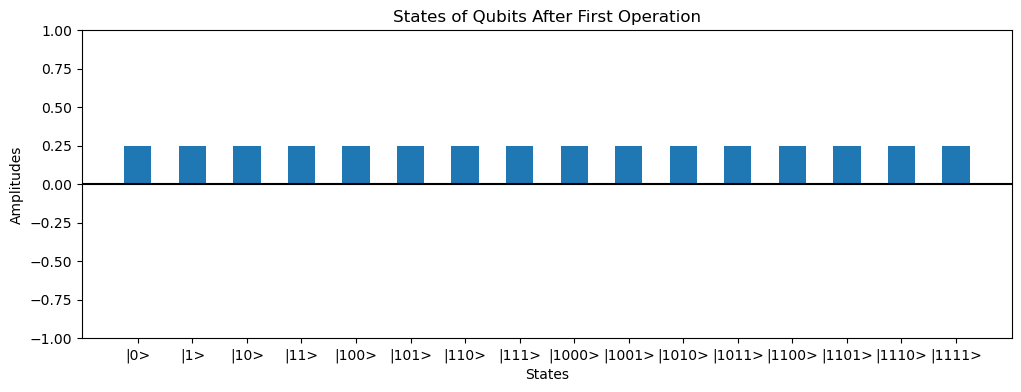

In [115]:
import matplotlib.pyplot as plt

figure_FirstDumpMachine = plt.figure(figsize=(12, 4))
plt.axhline(y=0, color='k', linestyle='-')
plt.bar(firstStates, firstAmplitudes, width = 0.5)
plt.ylim([-1, 1])
plt.xlabel('States')
plt.ylabel('Amplitudes')
plt.title('States of Qubits After First Operation')
plt.show()

In [116]:
secondAmplitudes = []
secondStates = []
DumpMachine2 = diagnostics[1]['amplitudes']

secondValueList = list(DumpMachine2.values())

def StateConversion(num):
    result = bin(num).replace("0b", "")
    stateString = "|" + result + ">"
    secondStates.append(stateString)   
    
for element in range(0,len(secondValueList)):
    output = list(secondValueList[element].values())
    if abs(round(output[2],3)) != 0:
        secondAmplitudes.append(round(output[2],3))
        StateConversion(element)

print(secondAmplitudes)
print(secondStates)

[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
['|11000>', '|11001>', '|11010>', '|11011>', '|11100>', '|11101>', '|11110>', '|11111>', '|100000>', '|100001>', '|100010>', '|100011>', '|100100>', '|100101>', '|100110>', '|100111>']


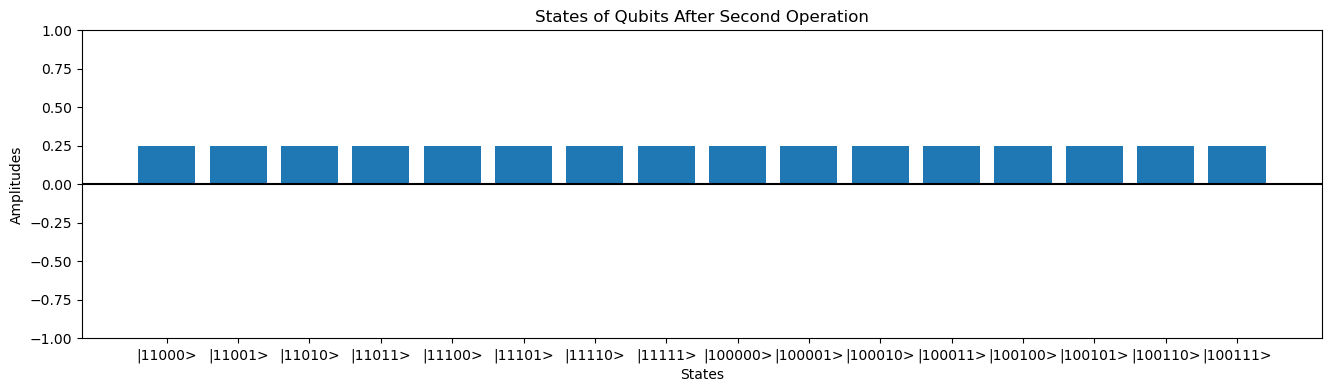

In [117]:
figure_SecondDumpMachine = plt.figure(figsize=(16, 4))
plt.axhline(y=0, color='k', linestyle='-')
plt.bar(secondStates, secondAmplitudes)
plt.ylim([-1, 1])
plt.xlabel('States')
plt.ylabel('Amplitudes')
plt.title('States of Qubits After Second Operation')
plt.show()

In [118]:
thirdAmplitudes = []
thirdStates = []
DumpMachine3 = diagnostics[2]['amplitudes']

thirdValueList = list(DumpMachine3.values())

def StateConversion(num):
    result = bin(num).replace("0b", "")
    stateString = "|" + result + ">"
    thirdStates.append(stateString)   
    
for element in range(0,len(thirdValueList)):
    output = list(thirdValueList[element].values())
    if abs(round(output[2],3)) != 0:
        thirdAmplitudes.append(round(output[2],3))
        StateConversion(element)

print(thirdAmplitudes)
print(thirdStates)

[1.0]
['|0>']


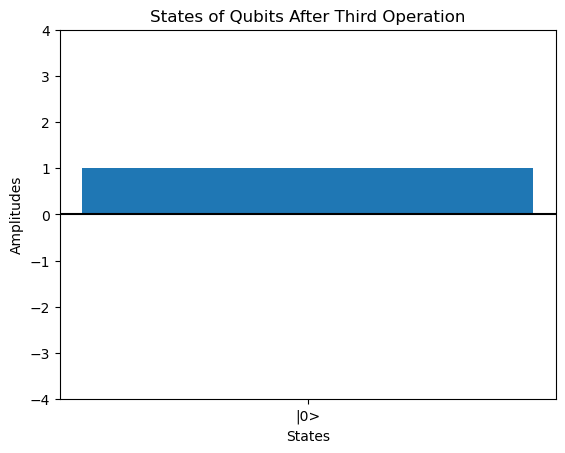

In [119]:
figure_ThirdDumpMachine = plt.figure()
plt.axhline(y=0, color='k', linestyle='-')
plt.bar(thirdStates, thirdAmplitudes, width = 0.3)
plt.ylim([-4, 4])
plt.xlabel('States')
plt.ylabel('Amplitudes')
plt.title('States of Qubits After Third Operation')
plt.show()